# Enhance BART with a Tensorflow-Regularization  (TF Computation Graph)

**Authors**: [Guanxiong Luo](mailto:guanxiong.luo@med.uni-goettingen.de), [Nick Scholand](mailto:nick.scholand@med.uni-goettingen.de), [Christian Holme](mailto:christian.holme@med.uni-goettingen.de)

**Presenter**: [Guanxiong Luo](mailto:guanxiong.luo@med.uni-goettingen.de)

**Institution**: University Medical Center Göttingen

**Reference**:
> [1] Luo, G, Blumenthal, M, Uecker, M. Using data-driven image priors for image reconstruction with BART Proc. Intl. Soc. Mag. Reson. Med. 29 (2021) P.1756

> [2] Luo, G, Zhao, N, Jiang, W, Hui, ES, Cao, P. MRI reconstruction using deep Bayesian estimation. Magn Reson Med. 2020; 84: 2246– 2261. https://doi.org/10.1002/mrm.28274

> [3] Salimans T, Karpathy A, Chen X, Kingma DP. Pixelcnn++: improving the pixelcnn with discretized logistic mixture likelihood and other modifications. arXiv preprint arXiv:1701.05517, 2017.

## Overview
This tutorial is to present how to create a regularization term with tensorflow and use it for image reconstruction in [BART](https://github.com/mrirecon/bart).

<img src="https://github.com/mrirecon/bart-workshop/raw/master/ismrm2021/bart_tensorflow/over.png" width="800"/>

## What we have
TensorFlow provides a C API that can be used to build bindings for other languages. 

1. BART src/nn/tf_wrapper.c

    * create tensors, create tf session

    * import the exported graph

    * restore the session from the saved model

    * get operation nodes from the graph

    * execute operation with session.run()


2. TensorFlow C Libraries [2.4.0](https://storage.googleapis.com/tensorflow/libtensorflow/libtensorflow-gpu-linux-x86_64-2.4.0.tar.gz)

3. A python program to export graph and weights (if any)

## What you can do with tf graph

> We can create the regularization term $R(x)$ with tf graph for image reconstruction (integrated in BART's `pics` tool).

$$\underset{x}{\arg \min}\ \|Ax-y\|^2+\lambda R(x)$$

## What you can learn here

1. simple example $R(x)=\|x\|^2$ without trainable weights

2. $R(x)=\log p(x, net(\Theta,x))$ with trainable weights $\Theta$, $net$ is represented as a prior [2]

## Check GPU
In the beginning of this tutorial we need to check which GPU type we got from Google Colab. Free users are provided with either a Tesla T4, a Tesla P100-PCIE-16GB or a Tesla K80 GPU.

In [ ]:
%%bash

# Estimate GPU Type
GPU_NAME=$(nvidia-smi --query-gpu=gpu_name --format=csv,noheader)

echo "GPU Type:"
echo $GPU_NAME

if [ "Tesla K80" = "$GPU_NAME" ];
then
    echo "GPU type Tesla K80 does not support CUDA 11. Set CUDA to version 10.1."

    # Install CUDA-10.1 if not already installed
    apt-get install cuda-10-1 cuda-drivers &> /dev/null

    # Change default CUDA to version 10.1
    cd /usr/local
    rm cuda
    ln -s cuda-10.1 cuda

else
    echo "GPU Information:"
    nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv
    nvcc --version
    echo "Current GPU supports default CUDA-11."
    echo "No further actions are necessary."
fi

In [ ]:
import os

# Set Library path for current CUDA version
os.environ['LD_LIBRARY_PATH'] = "/usr/local/cuda/lib64"

## Part 0: Download Supporting Material

This tutorial requires additional data including radial k-space spokes, a trained model and some python functions. If you want to follow up this tutorial execute the following cell, which downloads the required files.

In [4]:
# Download the required supporting materials
! wget -q https://raw.githubusercontent.com/mrirecon/bart-workshop/master/ismrm2021/bart_tensorflow/data.zip
! unzip data.zip


Archive:  data.zip
  inflating: ksp_256.cfl             
 extracting: ksp_256.hdr             
   creating: prior/
  inflating: prior/pixel_cnn.data-00000-of-00001  
  inflating: prior/pixel_cnn.index   
  inflating: prior/pixel_cnn.meta    
  inflating: prior/pixel_cnn.pb      
  inflating: traj_256.cfl            
 extracting: traj_256.hdr            
  inflating: utils.py                


## Part I: How to Create a TF Graph for BART

The first part of this tutorial is about creating a TF graph, which can be used with BART. Therefore, we need load some python libraries.

In [ ]:
!pip install tensorflow==2.4.0

In [1]:
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

import numpy as np

### Step 1: Define Input $x$

We define a TF object for our input.

In [2]:
image_shape = [256, 256, 2]
batch_size = 1

# CAPI -> TF_GraphOperationByName(graph, "input_0")
# give name with input_0, ..., input_I 
x = tf.placeholder(tf.float32,
                   shape=[batch_size]+image_shape,
                   name='input_0')
v = tf.Variable(1.)
x = x * v

### Step 2: Set Output to TF's l2 Loss

In the later following reconstruction example we want to validate the integration of TF graphs in BART with an l2 regularization example. 

Therefore, we are going to compare a reconstruction with the internal l2 loss of the `pics` tool with the result using a TF graph regularization.

The required graph is now set to have TF's l2 loss as an output.

In [3]:
l2 = tf.nn.l2_loss(x)#/np.product(image_shape)/batch_size        #R(x)=|x|^2
# CAPI -> TF_GraphOperationByName(graph, "output_0") -> nlop forward
# give name with output_0, ..., output_I
output = tf.identity(tf.stack([l2, tf.ones_like(l2)], axis=-1), name='output_0') 

### Step 3: Define the Gradient of TF's l2 Loss

For being able to use the TF graph as a regularization inside of a larger iterative optimization algorithm, we need to know its gradients, which are defined in the following.

In [4]:
grad_ys = tf.placeholder(tf.float32,
                         shape=[2],
                         name='grad_ys_0')

# CAPI -> TF_GraphOperationByName(graph, "grad_0") -> nlop adj
grads = tf.squeeze(tf.gradients(output, x, grad_ys), name='grad_0') 

### Step 4: Export the Graph and Weights

The created l2 loss graph needs to be stored in a BART understandable format, which allows us to pass it to the `pics` command of BART's CLI. Therefore, we exploit the `export_model` function.

In [5]:
from utils import export_model

# Definition of function:
#         export_model(model_path, exported_path, name, as_text, use_gpu):

export_model(None, "./", "l2_toy", as_text=False, use_gpu=False)

Exported


Let us have a look how the exported files look like.

In [6]:
!ls

bart_tf_2.ipynb  data.zip		     l2_toy.meta     traj_256.cfl
bart_tf.ipynb	 ksp_256.cfl		     l2_toy.pb	     traj_256.hdr
checkpoint	 ksp_256.hdr		     prior	     utils.py
clean		 l2_toy.data-00000-of-00001  __pycache__
cmd.png		 l2_toy.index		     Tensorflow.png


##  Part II: How to Use the TF Graph in BART

###  Step 1: Setup BART and TF

#### TF C API

First we need to **download the TF C API**

In [7]:
%%bash

# Download tensorflow c libraries
wget -q https://storage.googleapis.com/tensorflow/libtensorflow/libtensorflow-gpu-linux-x86_64-2.4.0.tar.gz
mkdir tensorflow && tar -C tensorflow -xvzf libtensorflow-gpu-linux-x86_64-2.4.0.tar.gz

./
./include/
./include/tensorflow/
./include/tensorflow/c/
./include/tensorflow/c/c_api.h
./include/tensorflow/c/c_api_experimental.h
./include/tensorflow/c/c_api_macros.h
./include/tensorflow/c/tensor_interface.h
./include/tensorflow/c/tf_attrtype.h
./include/tensorflow/c/tf_datatype.h
./include/tensorflow/c/tf_file_statistics.h
./include/tensorflow/c/tf_status.h
./include/tensorflow/c/tf_tensor.h
./include/tensorflow/c/tf_tstring.h
./include/tensorflow/core/
./include/tensorflow/core/platform/
./include/tensorflow/core/platform/ctstring.h
./include/tensorflow/core/platform/ctstring_internal.h
./lib/
./lib/libtensorflow.so.2.4.0
./lib/libtensorflow_framework.so.2.4.0
./lib/libtensorflow_framework.so
./lib/libtensorflow_framework.so.2
./lib/libtensorflow.so
./lib/libtensorflow.so.2
./THIRD_PARTY_TF_C_LICENSES
./LICENSE
./include/tensorflow/c/eager/
./include/tensorflow/c/eager/c_api.h
./include/tensorflow/c/eager/c_api_experimental.h
./include/tensorflow/c/eager/dlpack.h


and need to set the required environmental variables

In [8]:
%env LIBRARY_PATH=/content/tensorflow/include 
%env LD_LIBRARY_PATH=/content/tensorflow/lib
%env TF_CPP_MIN_LOG_LEVEL=3

env: LIBRARY_PATH=/content/tensorflow/include
env: LD_LIBRARY_PATH=/content/tensorflow/lib
env: TF_CPP_MIN_LOG_LEVEL=3


#### Download and Compile BART

In [9]:
%%bash

# Install BARTs dependencies
apt-get install -y make gcc libfftw3-dev liblapacke-dev libpng-dev libopenblas-dev &> /dev/null

# Download BART version

[ -d /content/bart ] && rm -r /content/bart
git clone https://github.com/mrirecon/bart/ bart

[ -d "bart" ] && echo "BART was downloaded successfully."

BART was downloaded successfully.


Cloning into 'bart'...
Checking out files: 100% (739/739), done.


After downloading BART we need to compile it. Make sure the flags

- `TENSORFLOW=1`
- `TENSORFLOW_BASE=../tensorflow/`,

which are required to intgrate TF graphs in BART, are set.

In [10]:
%%bash

cd bart

# Switch to desired branch of the BART project
BRANCH=ISMRM21
git checkout -q $BRANCH

# Define specifications 
COMPILE_SPECS=" PARALLEL=1
                TENSORFLOW=1
                TENSORFLOW_BASE=../tensorflow/"

printf "%s\n" $COMPILE_SPECS > Makefiles/Makefile.local

make &> /dev/null

After compilation of BART we need to set the required environmental variable: `TOOLBOX_PATH`

In [18]:
%env TOOLBOX_PATH=/content/bart

env: TOOLBOX_PATH=/home/jason/gluo_remote/ISMRM/ismrm-2021-software-session/05_bart_tf/bart/bart


Additionally, we add the compiled `bart` executable to our `PATH` variable

In [19]:
import os
os.environ['PATH'] = os.environ['TOOLBOX_PATH'] + ":" + os.environ['PATH']

### Step 2: Help Information for TF Graph in BART's `pics`

In the second step we look into the help for BART's regularization options for the `pics` tool.

In [20]:
!which bart
!bart pics -Rh

/usr/local/bin/bart
Generalized regularization options (experimental)

-R <T>:A:B:C	<T> is regularization type (single letter),
		A is transform flags, B is joint threshold flags,
		and C is regularization value. Specify any number
		of regularization terms.

-R Q:C    	l2-norm in image domain
-R I:B:C  	l1-norm in image domain
-R W:A:B:C	l1-wavelet
-R N:A:B:C	Normalized Iterative Hard Thresholding (NIHT), image domain
		C is an integer percentage, i.e. from 0-100
-R H:A:B:C	NIHT, wavelet domain
-R F:A:B:C	l1-Fourier
-R T:A:B:C	total variation
-R M2:C    	manifold l2-norm in image domain
-R M1:C    	manifold l1-norm in image domain
-R T:7:0:.01	3D isotropic total variation with 0.01 regularization.
-R L:7:7:.02	Locally low rank with spatial decimation and 0.02 regularization.
-R M:7:7:.03	Multi-scale low rank with spatial decimation and 0.03 regularization.


You can find a list of regularization terms $R(x)$, which can be added to the optimization of
$$
\hat{x}=\underset{x}{\arg \min} \|x-v\|^2 + \lambda R(x)
$$

To integrate a TF graph as regularization term in `pics` use the notation `-R TF:{graph_path}:lambda`. 

And for tensorflow-regularizer, the gradient of $R(x)$ with respect to $x$ is used to for the update direction of $x$.

### Step 3: Extract Radial Spokes and Compute Coil Sensitivities

The dataset we downloaded provides us with radial k-space data consisting of 160 spokes following a sampling scheme rotated by the 7th golden angle.

For this tutorial we will use the first 60 spokes and extract them from the original dataset.

In [16]:
%%bash

# Extract spokes from original dataset

spokes=60

bart extract 2 0 $spokes ksp_256 ksp_256_c
bart extract 2 0 $spokes traj_256 traj_256_c

To be able to exploit ESPIRiT for coil sensitivity estimation, we need to grid the non-Cartesian (radial) dataset. Instead of gridding it directly we use the internal gridding of the inverse `nufft` tool and project the result back into k-space with a regular `fft`.

In [17]:
%%bash

# Grid non-Cartesian k-space data

bart nufft -i traj_256_c ksp_256_c zero_filled
bart fft $(bart bitmask 0 1) zero_filled grid_ksp


Est. image size: 256 256 1
Done.


After gridding the radial dataset, we can use ESPIRiT to estimate the coil sensitivity maps.

In [18]:
%%bash

# Estimate coil-sensitivities with ESPIRiT

bart ecalib -r20 -m1 -c0.0001 grid_ksp coilsen_esp

Done.


## Example 1: TF Graph as l2 Regularization

In this first example we use the TF graph as an l2 regularization term. We pass the TF graph following the `-R TF:{graph_path}:lambda` notation for `pics` regularization terms.

In [19]:
# Reconstruct with TF Graph as l2 regularization
# if you get a GPU K80 on colab, run this cell without gpu by setting CUDA_VISIBLE_DEVICES=-1

!bart pics -i100 -R TF:{$(pwd)/l2_toy}:0.02 -d5 -e -t traj_256_c ksp_256_c coilsen_esp l2_pics_tf

[  1 256  60   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
[256 256   1   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
ksp : [  1 256  60   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [256 256   1   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 256  60   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
NUFFT: Toeplitz mode
nufft kernel dims: [  1 256  60   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
nufft psf dims:    [512 512   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
nufft traj dims:   [  3 256  60   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
Allocating 15360 (vs. 277504) + 262144
ksp : [  1 256  60   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [512 512   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 256  60   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
Scaling: 17.102392  (max = 26.653936/p90 = 17.102392/median = 

After reconstruction of the dataset with the TF graph as loss we validate it by comparing it to the built-in l2 regularization in `pics` called by adding the `-l2` flag to the CLI call.

In [20]:
# Reconstruct with built-in l2 regularization

!bart pics -l2 -r 0.01 -e -d5 -t traj_256_c ksp_256_c coilsen_esp l2_pics

[  1 256  60   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
[256 256   1   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
ksp : [  1 256  60   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [256 256   1   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 256  60   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
NUFFT: Toeplitz mode
nufft kernel dims: [  1 256  60   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
nufft psf dims:    [512 512   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
nufft traj dims:   [  3 256  60   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
Allocating 15360 (vs. 277504) + 262144
ksp : [  1 256  60   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [512 512   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 256  60   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
Scaling: 17.102394  (max = 26.653936/p90 = 17.102394/median = 

For an improved comparison we visualize them next to each other.

(-0.5, 255.5, 255.5, -0.5)

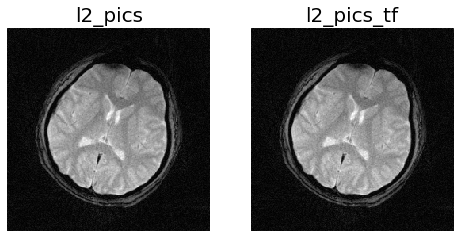

In [21]:
from utils import *
import matplotlib.pyplot as plt
fig, axis = plt.subplots(figsize=(8,4), ncols=2)
l2_pics = readcfl("l2_pics")
l2_pics_tf = readcfl("l2_pics_tf")

axis[0].imshow(abs(l2_pics), cmap='gray', interpolation='None')
axis[1].imshow(abs(l2_pics_tf), cmap='gray', interpolation='None')
axis[0].set_title("l2_pics", fontsize=20)
axis[1].set_title("l2_pics_tf", fontsize=20)
axis[0].axis('off')
axis[1].axis('off')

## Example 2: $R(x)=\log p(x, net(x))$ 

After validating the TF graph import as regularization based on the l2 regularization, we want to apply prior knowledge that is learned for high-quality images to our reconstruction [2]. The prior knowledge is log likelihood term served as a regularization term on image.

$$\log P(\hat{\Theta}, \boldsymbol{x}) =  \log p(\boldsymbol{x};\mathcal{NET}(\hat{\Theta}, \boldsymbol{x}))=\log p(x^{(1)})\prod_{i=2}^{n^2} p(x^{(i)}\mid x^{(1)},..,x^{(i-1)})$$

where the neural network $\mathcal{NET}(\hat{\Theta}, \boldsymbol{x})$ outputs the distribution parameters of the mixture of logistic distribution which was used to model images [2,3].

We already downloaded the pretrained prior and can have a look into its files

In [22]:
!ls prior/

pixel_cnn.data-00000-of-00001  pixel_cnn.index	pixel_cnn.meta	pixel_cnn.pb


We need to generate weights for a density compensation in the following reconstruction. This can be done with the following bart commands. To use the result from BART's CLI we need to convert it into the .cfl format. Here, we use the `writecfl` function of BART's python interface.

In [ ]:
writecfl("weights", gen_weights(60, 256))

Now we can start the reconstruction with the pre-trained prior.

Again we pass the information about our regularization using the `-R TF:{graph_path}:lambda` notation of `pics` regularization. We run the reconstruction for 30 iterations.

In [24]:
# if you get a GPU K80 on colab, run this cell without gpu by setting CUDA_VISIBLE_DEVICES=-1

!bart pics -i30 -R TF:{./prior/pixel_cnn}:8 -d5 -e -I -p weights -t traj_256_c ksp_256_c coilsen_esp w_pics_prior

[  1 256  60   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
[256 256   1   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
ksp : [  1 256  60   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [256 256   1   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 256  60   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
wgh : [  1 256  60   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
NUFFT: Toeplitz mode
nufft kernel dims: [  1 256  60   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
nufft psf dims:    [512 512   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
nufft traj dims:   [  3 256  60   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
Allocating 15360 (vs. 277504) + 262144
ksp : [  1 256  60   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [512 512   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 256  60   1   1   1   1   1   1   1   1   1   1   1   1   1

Finally, we can compare the results for the built-in l2, TF l2 and prior regularized reconstruction with the `pics` tool in BART. We visualize all results next to each other.

(-0.5, 255.5, 255.5, -0.5)

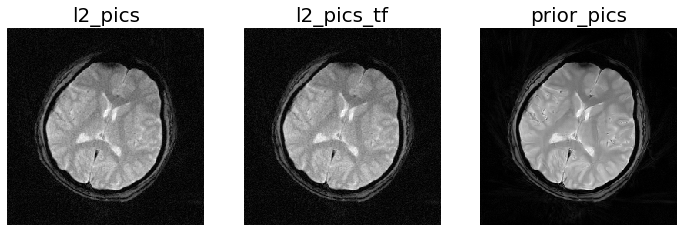

In [25]:
import matplotlib.pyplot as plt
pics_prior = readcfl("w_pics_prior")
fig, axis = plt.subplots(figsize=(12,4), ncols=3)

axis[0].imshow(abs(l2_pics), cmap='gray', interpolation='None')
axis[0].set_title("l2_pics", fontsize=20)
axis[1].imshow(abs(l2_pics_tf), cmap='gray', interpolation='None')
axis[1].set_title("l2_pics_tf", fontsize=20)
axis[2].imshow(abs(pics_prior), cmap='gray', interpolation='None')
axis[2].set_title("prior_pics", fontsize=20)
axis[0].axis('off')
axis[1].axis('off')
axis[2].axis('off')


In [26]:
! bash clean

bash: clean: No such file or directory
